# Introduction

**Aim of the notebook**  

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
fine-tune, by optimizing all weights, and compare the test accuracy of the baseline model versus fine-tuning a LoRA.

The neural network that we define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



**References** 

- https://arxiv.org/pdf/2106.09685.pdf

- https://lightning.ai/pages/community/tutorial/lora-llm/

- https://huggingface.co/docs/diffusers/main/en/training/lora


# Imports

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)

# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (
    torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

path_model = "./model/LoRA/model.pt"
path_state_dic = "./model/LoRA/state_dic.pt"

NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# MNIST Dataset 0 to 4

In [4]:
# These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

mnist_train = datasets.MNIST(
    root='./data/LoRA', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(
    root='./data/LoRA', train=False, download=True, transform=transform)

class_names = [0, 1, 2, 3, 4]
train_mask = torch.tensor(
    [label in class_names for label in mnist_train.targets])
test_mask = torch.tensor(
    [label in class_names for label in mnist_test.targets])

train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(
    train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(val_dataset), len(test_dataset)

(21417, 9179, 5139)

### Classifier

In [5]:
# note that last layer has 5 neurons for digits 0...4
# and the same layer will be used for 5...9


class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier, self).__init__()

        self.linear1 = nn.Linear(28 * 28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 5)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, img):
        x = img.view(-1, 28 * 28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x


net = classifier().to(device)

### Training and Validation

In [6]:
# We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
# so that fine-tuning don't change pre-training weights too much.


# Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)


# to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
# so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range


# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if "subset2" in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()

    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(
        loader, desc=f"Training" if optimizer else f"Validation")
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28 * 28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)


def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())

    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(
            train_loader, name, net, optimizer, cross_el, total_iterations_limit
        )
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)

        val_loss = run_epoch(
            val_loader, name, net, None, cross_el, total_iterations_limit
        )
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)

    return train_loss_lst, val_loss_lst

In [7]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst, label="train")
    plt.plot(val_loss_lst, label="val")
    plt.legend()

In [ ]:
# Optional if already run
 
train_loss_lst, val_loss_lst = train(
    train_loader, val_loader, "subset1", net, epochs=30)

plot_losses(train_loss_lst, val_loss_lst)

torch.save(net, path_model)
torch.save(net.state_dict(), path_state_dic)

### Weights

In [8]:
net = torch.load(path_model).to(device)

In [9]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

# original_weights
original_weights["linear1.weight"]

tensor([[0.0213, 0.0210, 0.0289,  ..., 0.0252, 0.0241, 0.0247],
        [0.0121, 0.0117, 0.0100,  ..., 0.0099, 0.0122, 0.0118],
        [0.0117, 0.0116, 0.0114,  ..., 0.0120, 0.0122, 0.0111],
        ...,
        [0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
        [0.0278, 0.0217, 0.0207,  ..., 0.0196, 0.0253, 0.0254],
        [0.0263, 0.0281, 0.0205,  ..., 0.0281, 0.0176, 0.0231]],
       device='cuda:0')

In [10]:
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


### Test

In [12]:
net = torch.load(path_model).to(device)

In [14]:
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0

    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + \
                        5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1

                total += 1

    accuracy = round(correct / total, 3)
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')

    return accuracy


test(test_loader, "Testing", net, {i: 0 for i in range(5)})

Testing: 100%|██████████| 41/41 [00:02<00:00, 18.07it/s]

Accuracy: 0.994
Wrong counts for the digit 0: 5
Wrong counts for the digit 1: 3
Wrong counts for the digit 2: 13
Wrong counts for the digit 3: 1
Wrong counts for the digit 4: 9


0.994

# MNIST Dataset 5 to 9

In [15]:
class_names_subset2 = [5, 6, 7, 8, 9]
train_mask_subset2 = torch.tensor(
    [label in class_names_subset2 for label in mnist_train.targets])
test_mask_subset2 = torch.tensor(
    [label in class_names_subset2 for label in mnist_test.targets])

train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(
    train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(
    train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(
    val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(
    test_dataset_subset2, batch_size=batch_size, shuffle=False)

### No fine-tuning

In [16]:
net = torch.load(path_model).to(device)

In [17]:
test(test_loader_subset2, "Testing_subset2", net, {i: 0 for i in range(5, 10)})

Testing_subset2: 100%|██████████| 38/38 [00:02<00:00, 14.15it/s]

Accuracy: 0.38
Wrong counts for the digit 5: 772
Wrong counts for the digit 6: 923
Wrong counts for the digit 7: 819
Wrong counts for the digit 8: 303
Wrong counts for the digit 9: 197


0.38

### Fine-tuning

In [18]:
net = torch.load(path_model).to(device)

In [19]:
train_loss_lst, val_loss_lst = train(
    train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)

Training: 100%|██████████| 161/161 [00:10<00:00, 15.85it/s, loss=5.34]


Epoch [1/10] Train Loss: 5.340674250762655


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.26it/s, loss=3.78]


Epoch [1/10] Validation Loss: 3.7810199329818506


Training: 100%|██████████| 161/161 [00:06<00:00, 23.49it/s, loss=3.35]


Epoch [2/10] Train Loss: 3.3468650483196565


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.07it/s, loss=2.23]


Epoch [2/10] Validation Loss: 2.2348621928173564


Training: 100%|██████████| 161/161 [00:05<00:00, 28.77it/s, loss=2.08]


Epoch [3/10] Train Loss: 2.0819573739300603


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.06it/s, loss=1.32]


Epoch [3/10] Validation Loss: 1.3158525098925051


Training: 100%|██████████| 161/161 [00:07<00:00, 21.09it/s, loss=1.31]


Epoch [4/10] Train Loss: 1.3051231455358658


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.30it/s, loss=0.793]


Epoch [4/10] Validation Loss: 0.7927469969659612


Training: 100%|██████████| 161/161 [00:06<00:00, 23.21it/s, loss=0.865]


Epoch [5/10] Train Loss: 0.8648056832159529


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.55it/s, loss=0.554]


Epoch [5/10] Validation Loss: 0.5544938224813213


Training: 100%|██████████| 161/161 [00:06<00:00, 24.52it/s, loss=0.664]


Epoch [6/10] Train Loss: 0.6642728771852411


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.75it/s, loss=0.435]


Epoch [6/10] Validation Loss: 0.4346077148465143


Training: 100%|██████████| 161/161 [00:08<00:00, 19.36it/s, loss=0.539]


Epoch [7/10] Train Loss: 0.5390786276841015


Validation: 100%|██████████| 69/69 [00:03<00:00, 19.64it/s, loss=0.359]


Epoch [7/10] Validation Loss: 0.3586879655502845


Training: 100%|██████████| 161/161 [00:06<00:00, 23.56it/s, loss=0.465]


Epoch [8/10] Train Loss: 0.4652713191990527


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.84it/s, loss=0.306]


Epoch [8/10] Validation Loss: 0.3055652986834015


Training: 100%|██████████| 161/161 [00:06<00:00, 24.91it/s, loss=0.412]


Epoch [9/10] Train Loss: 0.41176366445070467


Validation: 100%|██████████| 69/69 [00:03<00:00, 21.42it/s, loss=0.268]


Epoch [9/10] Validation Loss: 0.26763056704531546


Training: 100%|██████████| 161/161 [00:08<00:00, 19.77it/s, loss=0.366]


Epoch [10/10] Train Loss: 0.3660839651682362


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.73it/s, loss=0.239]

Epoch [10/10] Validation Loss: 0.23887178366598877


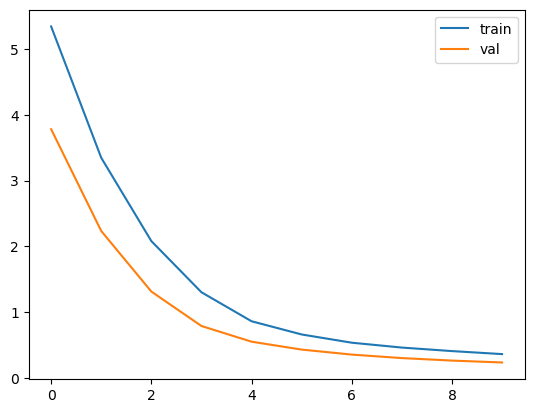

In [20]:
plot_losses(train_loss_lst, val_loss_lst)

In [21]:
accuracy_fine_tuning = test(
    test_loader_subset2, "Testing_subset2", net, {i: 0 for i in range(5, 10)}
)

Testing_subset2: 100%|██████████| 38/38 [00:02<00:00, 15.95it/s]

Accuracy: 0.927
Wrong counts for the digit 5: 74
Wrong counts for the digit 6: 39
Wrong counts for the digit 7: 81
Wrong counts for the digit 8: 94
Wrong counts for the digit 9: 68


### Fine-tuning with LoRA

##### Modified Classifier

In [64]:
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()

        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path_state_dic))

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Define lora hyperparameters
        self.lora_rank = lora_rank

        # Define lora weights matrices for each layer in pretrained model
        self.l1_lora_A = nn.Parameter(
            torch.empty(self.pretrained_net.linear1.in_features,
                        self.lora_rank)
        )
        self.l1_lora_B = nn.Parameter(
            torch.empty(self.lora_rank,
                        self.pretrained_net.linear1.out_features)
        )

        self.l2_lora_A = nn.Parameter(
            torch.empty(self.pretrained_net.linear2.in_features,
                        self.lora_rank)
        )
        self.l2_lora_B = nn.Parameter(
            torch.empty(self.lora_rank,
                        self.pretrained_net.linear2.out_features)
        )

        self.l3_lora_A = nn.Parameter(
            torch.empty(self.pretrained_net.linear3.in_features,
                        self.lora_rank)
        )
        self.l3_lora_B = nn.Parameter(
            torch.empty(self.lora_rank,
                        self.pretrained_net.linear3.out_features)
        )

        # Initialization for lora layers

        # A_init = nn.init.normal_
        # A_init(self.l1_lora_A, std=math.sqrt(1/self.lora_rank))
        # A_init(self.l2_lora_A, std=math.sqrt(1/self.lora_rank))
        # A_init(self.l3_lora_A, std=math.sqrt(1/self.lora_rank))

        A_init = nn.init.normal_
        A_init(self.l1_lora_A)
        A_init(self.l2_lora_A)
        A_init(self.l3_lora_A)
        
        # nn.init.kaiming_uniform_(self.l1_lora_A, a=math.sqrt(5))
        # nn.init.kaiming_uniform_(self.l2_lora_A, a=math.sqrt(5))            
        # nn.init.kaiming_uniform_(self.l3_lora_A, a=math.sqrt(5))

        B_init = nn.init.zeros_
        B_init(self.l1_lora_B)
        B_init(self.l2_lora_B)
        B_init(self.l3_lora_B)

        # Freeze non lora weights
        self.pretrained_net.linear1.weight.requires_grad = False
        self.pretrained_net.linear1.bias.requires_grad = False
        self.pretrained_net.linear2.weight.requires_grad = False
        self.pretrained_net.linear2.bias.requires_grad = False
        self.pretrained_net.linear3.weight.requires_grad = False
        self.pretrained_net.linear3.bias.requires_grad = False

        # for param in self.pretrained_net.parameters():
        #   param.requires_grad = False

    def lora_linear(self, x, layer, lora_A, lora_B):
        # h = x @ layer.weight.transpose(0, 1)
        h = layer(x)
        h += x @ lora_A @ lora_B # * 1/self.lora_rank
        return h

    def forward(self, input):
        """Mimics the classifier model replacing linear layer by lora layers"""
        x = input.view(-1, 28 * 28)

        x = self.lora_linear(
            x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B
        )
        x = self.relu(x)
        x = self.dropout(x)

        x = self.lora_linear(
            x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B
        )
        x = self.relu(x)
        x = self.dropout(x)

        x = self.lora_linear(
            x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B
        )

        return x


lora_rank = 1
modified_net = ModifiedClassifier(lora_rank).to(device)
modified_net

ModifiedClassifier(
  (pretrained_net): classifier(
    (linear1): Linear(in_features=784, out_features=1000, bias=True)
    (linear2): Linear(in_features=1000, out_features=2000, bias=True)
    (linear3): Linear(in_features=2000, out_features=5, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

##### Parameters

In [65]:
def count_lora_param(model):
    param_c = 0

    lora_param_names = [f"l{i}_lora_{mat}" for i in range(1, 4) for mat in ["A", "B"]]

    for name, param in model.named_parameters():
        if name in lora_param_names:
            param_c += torch.numel(param)

    return param_c

count_lora_param(modified_net)

434496

##### Fine-Tuning with LoRA rank 1

In [60]:
print(f"LoRA rank: {modified_net.lora_rank}")

train_loss_lst, val_loss_lst = train(
    train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10
)

LoRA rank: 64


Training: 100%|██████████| 161/161 [00:12<00:00, 12.80it/s, loss=3.79]


Epoch [1/10] Train Loss: 3.7872068741306757


Validation: 100%|██████████| 69/69 [00:03<00:00, 19.81it/s, loss=1.47]


Epoch [1/10] Validation Loss: 1.4697071158367654


Training: 100%|██████████| 161/161 [00:07<00:00, 21.91it/s, loss=1.24]


Epoch [2/10] Train Loss: 1.2356829091628887


Validation: 100%|██████████| 69/69 [00:03<00:00, 20.31it/s, loss=0.52] 


Epoch [2/10] Validation Loss: 0.5195662504520969


Training: 100%|██████████| 161/161 [00:07<00:00, 22.83it/s, loss=0.656]


Epoch [3/10] Train Loss: 0.6560387905710232


Validation: 100%|██████████| 69/69 [00:03<00:00, 20.10it/s, loss=0.326]


Epoch [3/10] Validation Loss: 0.3263689942549968


Training: 100%|██████████| 161/161 [00:05<00:00, 27.76it/s, loss=0.468]


Epoch [4/10] Train Loss: 0.46804268297201357


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.16it/s, loss=0.247]


Epoch [4/10] Validation Loss: 0.24699907955052197


Training: 100%|██████████| 161/161 [00:06<00:00, 26.44it/s, loss=0.375]


Epoch [5/10] Train Loss: 0.3746408797013834


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.47it/s, loss=0.207]


Epoch [5/10] Validation Loss: 0.20730855143156604


Training: 100%|██████████| 161/161 [00:05<00:00, 26.96it/s, loss=0.313]


Epoch [6/10] Train Loss: 0.3126354731665635


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.56it/s, loss=0.18] 


Epoch [6/10] Validation Loss: 0.18034242071967194


Training: 100%|██████████| 161/161 [00:05<00:00, 27.14it/s, loss=0.282]


Epoch [7/10] Train Loss: 0.2820930921513101


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.51it/s, loss=0.163]


Epoch [7/10] Validation Loss: 0.16276252950015274


Training: 100%|██████████| 161/161 [00:05<00:00, 27.30it/s, loss=0.258]


Epoch [8/10] Train Loss: 0.25834528245725985


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.83it/s, loss=0.149]


Epoch [8/10] Validation Loss: 0.14934614257536072


Training: 100%|██████████| 161/161 [00:09<00:00, 17.44it/s, loss=0.236]


Epoch [9/10] Train Loss: 0.23622886896688747


Validation: 100%|██████████| 69/69 [00:03<00:00, 21.45it/s, loss=0.138]


Epoch [9/10] Validation Loss: 0.13805402205258177


Training: 100%|██████████| 161/161 [00:10<00:00, 14.98it/s, loss=0.214]


Epoch [10/10] Train Loss: 0.2143319354664465


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.12it/s, loss=0.131]

Epoch [10/10] Validation Loss: 0.1309068086354629


In [61]:
# Check that the frozen parameters are still unchanged by the finetuning

lora_fixed_weights = {}
for name, param in modified_net.pretrained_net.named_parameters():
    lora_fixed_weights[name] = param.clone().detach()
lora_fixed_weights["linear1.weight"]


for net_param, lora_fixed_param in zip(original_weights.values(), lora_fixed_weights.values()):
    assert np.array(net_param.detach().cpu()).sum() == np.array(lora_fixed_param.detach().cpu()).sum()

for name in original_weights.keys():
  assert original_weights[name].equal(lora_fixed_weights[name])

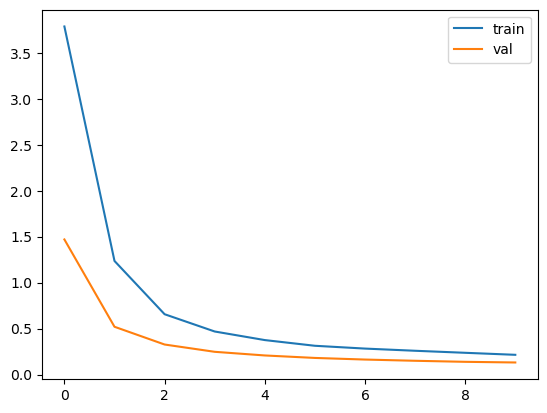

In [62]:
plot_losses(train_loss_lst, val_loss_lst)

In [63]:
accuracy_fine_tuning_lora_1 = test(
    test_loader_subset2, "Testing_subset2", modified_net, {i: 0 for i in range(5, 10)}
)

# 10-EPOCH FINE-TUNING 
# Accuracy: 0.416
# Wrong counts for the digit 5: 737
# Wrong counts for the digit 6: 913
# Wrong counts for the digit 7: 692
# Wrong counts for the digit 8: 340
# Wrong counts for the digit 9: 156

Testing_subset2: 100%|██████████| 38/38 [00:01<00:00, 19.87it/s]

Accuracy: 0.957
Wrong counts for the digit 5: 26
Wrong counts for the digit 6: 26
Wrong counts for the digit 7: 31
Wrong counts for the digit 8: 70
Wrong counts for the digit 9: 54


##### LoRA Rank

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added 

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9 

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

In [68]:
lora_ranks = [1, 2, 4, 8, 16, 32, 64]
lora_params = {}
accuracies = {}

for lora_rank in lora_ranks:

    model = ModifiedClassifier(lora_rank).to(device)
    lora_params[lora_rank] = count_lora_param(model)

    train_loss, val_loss = train(
        train_loader_subset2, val_loader_subset2, "subset2", model, epochs=10
    )
    
    accuracies[lora_rank] = test(
        test_loader_subset2, "Testing_subset2", model, 
        {i: 0 for i in range(5, 10)}
    )

Training:   0%|          | 0/161 [00:00<?, ?it/s]

Training: 100%|██████████| 161/161 [00:09<00:00, 17.09it/s, loss=6.64]


Epoch [1/10] Train Loss: 6.635475220887558


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.42it/s, loss=5.94]


Epoch [1/10] Validation Loss: 5.941112615060115


Training: 100%|██████████| 161/161 [00:08<00:00, 18.19it/s, loss=6.56]


Epoch [2/10] Train Loss: 6.555254589696848


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.08it/s, loss=5.85]


Epoch [2/10] Validation Loss: 5.8502177984818164


Training: 100%|██████████| 161/161 [00:05<00:00, 27.65it/s, loss=6.43]


Epoch [3/10] Train Loss: 6.430194215004488


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.40it/s, loss=5.75]


Epoch [3/10] Validation Loss: 5.751780364824378


Training: 100%|██████████| 161/161 [00:05<00:00, 27.05it/s, loss=6.35]


Epoch [4/10] Train Loss: 6.350260109634873


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.10it/s, loss=5.64]


Epoch [4/10] Validation Loss: 5.643589703933053


Training: 100%|██████████| 161/161 [00:06<00:00, 25.57it/s, loss=6.23]


Epoch [5/10] Train Loss: 6.230839412404884


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.76it/s, loss=5.53]


Epoch [5/10] Validation Loss: 5.527536661728568


Training: 100%|██████████| 161/161 [00:06<00:00, 26.53it/s, loss=6.09]


Epoch [6/10] Train Loss: 6.091595836307691


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.41it/s, loss=5.4] 


Epoch [6/10] Validation Loss: 5.4034343629643535


Training: 100%|██████████| 161/161 [00:05<00:00, 27.05it/s, loss=5.95]


Epoch [7/10] Train Loss: 5.952010975120971


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.71it/s, loss=5.27]


Epoch [7/10] Validation Loss: 5.270627913267716


Training: 100%|██████████| 161/161 [00:06<00:00, 24.25it/s, loss=5.85]


Epoch [8/10] Train Loss: 5.850967553831776


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.71it/s, loss=5.13]


Epoch [8/10] Validation Loss: 5.128577066504437


Training: 100%|██████████| 161/161 [00:06<00:00, 26.34it/s, loss=5.66]


Epoch [9/10] Train Loss: 5.657896192917913


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.48it/s, loss=4.98]


Epoch [9/10] Validation Loss: 4.983811222988626


Training: 100%|██████████| 161/161 [00:05<00:00, 27.24it/s, loss=5.54]


Epoch [10/10] Train Loss: 5.5399319414766675


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.16it/s, loss=4.84]


Epoch [10/10] Validation Loss: 4.842728939609251


Testing_subset2: 100%|██████████| 38/38 [00:01<00:00, 19.36it/s]


Accuracy: 0.397
Wrong counts for the digit 5: 645
Wrong counts for the digit 6: 910
Wrong counts for the digit 7: 703
Wrong counts for the digit 8: 506
Wrong counts for the digit 9: 166


Training: 100%|██████████| 161/161 [00:06<00:00, 25.83it/s, loss=6.55]


Epoch [1/10] Train Loss: 6.546708228425209


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.78it/s, loss=5.84]


Epoch [1/10] Validation Loss: 5.8384310128032295


Training: 100%|██████████| 161/161 [00:06<00:00, 26.42it/s, loss=6.4] 


Epoch [2/10] Train Loss: 6.397296834436262


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.08it/s, loss=5.64]


Epoch [2/10] Validation Loss: 5.640027509219404


Training: 100%|██████████| 161/161 [00:06<00:00, 26.63it/s, loss=6.2] 


Epoch [3/10] Train Loss: 6.196714344972409


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.87it/s, loss=5.41]


Epoch [3/10] Validation Loss: 5.411660256593124


Training: 100%|██████████| 161/161 [00:06<00:00, 24.19it/s, loss=5.89]


Epoch [4/10] Train Loss: 5.891680681927604


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.25it/s, loss=5.14]


Epoch [4/10] Validation Loss: 5.143260948899863


Training: 100%|██████████| 161/161 [00:06<00:00, 26.33it/s, loss=5.61]


Epoch [5/10] Train Loss: 5.611178909029279


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.81it/s, loss=4.83]


Epoch [5/10] Validation Loss: 4.833326868388964


Training: 100%|██████████| 161/161 [00:06<00:00, 25.41it/s, loss=5.33]


Epoch [6/10] Train Loss: 5.32891049000047


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.99it/s, loss=4.5] 


Epoch [6/10] Validation Loss: 4.495672713155332


Training: 100%|██████████| 161/161 [00:06<00:00, 26.26it/s, loss=5]   


Epoch [7/10] Train Loss: 4.999702105611007


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.60it/s, loss=4.14]


Epoch [7/10] Validation Loss: 4.143496001976124


Training: 100%|██████████| 161/161 [00:06<00:00, 25.89it/s, loss=4.61]


Epoch [8/10] Train Loss: 4.6131879039432695


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.05it/s, loss=3.79]


Epoch [8/10] Validation Loss: 3.7895667069200156


Training: 100%|██████████| 161/161 [00:06<00:00, 26.36it/s, loss=4.26]


Epoch [9/10] Train Loss: 4.261984644469267


Validation: 100%|██████████| 69/69 [00:03<00:00, 22.25it/s, loss=3.44]


Epoch [9/10] Validation Loss: 3.4369856965714605


Training: 100%|██████████| 161/161 [00:06<00:00, 25.55it/s, loss=3.9] 


Epoch [10/10] Train Loss: 3.899899998066588


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.55it/s, loss=3.09]


Epoch [10/10] Validation Loss: 3.09189336196236


Testing_subset2: 100%|██████████| 38/38 [00:01<00:00, 19.10it/s]


Accuracy: 0.54
Wrong counts for the digit 5: 696
Wrong counts for the digit 6: 344
Wrong counts for the digit 7: 536
Wrong counts for the digit 8: 448
Wrong counts for the digit 9: 210


Training: 100%|██████████| 161/161 [00:06<00:00, 26.17it/s, loss=6.46]


Epoch [1/10] Train Loss: 6.457271697358315


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.97it/s, loss=5.53]


Epoch [1/10] Validation Loss: 5.534309701643128


Training: 100%|██████████| 161/161 [00:06<00:00, 26.32it/s, loss=5.92]


Epoch [2/10] Train Loss: 5.915769571102924


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.20it/s, loss=5.04]


Epoch [2/10] Validation Loss: 5.042721817458886


Training: 100%|██████████| 161/161 [00:06<00:00, 26.60it/s, loss=5.39]


Epoch [3/10] Train Loss: 5.3879859728842785


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.24it/s, loss=4.52]


Epoch [3/10] Validation Loss: 4.518733173176862


Training: 100%|██████████| 161/161 [00:05<00:00, 27.01it/s, loss=4.86]


Epoch [4/10] Train Loss: 4.8635636590282365


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.53it/s, loss=3.95]


Epoch [4/10] Validation Loss: 3.9513329215671704


Training: 100%|██████████| 161/161 [00:06<00:00, 26.57it/s, loss=4.3] 


Epoch [5/10] Train Loss: 4.297313694628129


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.13it/s, loss=3.4] 


Epoch [5/10] Validation Loss: 3.4018932598224585


Training: 100%|██████████| 161/161 [00:06<00:00, 25.46it/s, loss=3.78]


Epoch [6/10] Train Loss: 3.7757318508550988


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.47it/s, loss=2.89]


Epoch [6/10] Validation Loss: 2.8909369586170586


Training: 100%|██████████| 161/161 [00:06<00:00, 25.18it/s, loss=3.27]


Epoch [7/10] Train Loss: 3.267317203261097


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.89it/s, loss=2.4] 


Epoch [7/10] Validation Loss: 2.3952582452608193


Training: 100%|██████████| 161/161 [00:07<00:00, 21.79it/s, loss=2.73]


Epoch [8/10] Train Loss: 2.7266319042407208


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.93it/s, loss=1.94]


Epoch [8/10] Validation Loss: 1.940793714661529


Training: 100%|██████████| 161/161 [00:07<00:00, 22.99it/s, loss=2.3] 


Epoch [9/10] Train Loss: 2.3022411506368505


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.97it/s, loss=1.59]


Epoch [9/10] Validation Loss: 1.5877636429192363


Training: 100%|██████████| 161/161 [00:06<00:00, 24.62it/s, loss=1.96]


Epoch [10/10] Train Loss: 1.961255359353486


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.56it/s, loss=1.34]


Epoch [10/10] Validation Loss: 1.335807192152825


Testing_subset2: 100%|██████████| 38/38 [00:01<00:00, 21.41it/s]


Accuracy: 0.721
Wrong counts for the digit 5: 394
Wrong counts for the digit 6: 279
Wrong counts for the digit 7: 260
Wrong counts for the digit 8: 296
Wrong counts for the digit 9: 128


Training: 100%|██████████| 161/161 [00:06<00:00, 26.06it/s, loss=6.13]


Epoch [1/10] Train Loss: 6.133677349327514


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.71it/s, loss=5.02]


Epoch [1/10] Validation Loss: 5.017184129659681


Training: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s, loss=5.14]


Epoch [2/10] Train Loss: 5.137187384670566


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.71it/s, loss=4.03]


Epoch [2/10] Validation Loss: 4.030109139456266


Training: 100%|██████████| 161/161 [00:06<00:00, 25.82it/s, loss=4.13]


Epoch [3/10] Train Loss: 4.129319769995553


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.18it/s, loss=3.01]


Epoch [3/10] Validation Loss: 3.0149978416553442


Training: 100%|██████████| 161/161 [00:05<00:00, 26.90it/s, loss=3.17]


Epoch [4/10] Train Loss: 3.1712886953946224


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.71it/s, loss=2.14]


Epoch [4/10] Validation Loss: 2.142000939535058


Training: 100%|██████████| 161/161 [00:06<00:00, 25.81it/s, loss=2.44]


Epoch [5/10] Train Loss: 2.4387685193778563


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.28it/s, loss=1.54]


Epoch [5/10] Validation Loss: 1.537917403207309


Training: 100%|██████████| 161/161 [00:06<00:00, 24.29it/s, loss=1.92]


Epoch [6/10] Train Loss: 1.9228144691597602


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.01it/s, loss=1.15]


Epoch [6/10] Validation Loss: 1.1500088175137837


Training: 100%|██████████| 161/161 [00:07<00:00, 22.94it/s, loss=1.51]


Epoch [7/10] Train Loss: 1.5146865770683526


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.99it/s, loss=0.932]


Epoch [7/10] Validation Loss: 0.9320877125297767


Training: 100%|██████████| 161/161 [00:06<00:00, 25.83it/s, loss=1.33]


Epoch [8/10] Train Loss: 1.3344722967710554


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.27it/s, loss=0.799]


Epoch [8/10] Validation Loss: 0.7989499737387118


Training: 100%|██████████| 161/161 [00:07<00:00, 22.15it/s, loss=1.18]


Epoch [9/10] Train Loss: 1.1760051254159916


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.62it/s, loss=0.709]


Epoch [9/10] Validation Loss: 0.7086073540259099


Training: 100%|██████████| 161/161 [00:10<00:00, 16.08it/s, loss=1.07]


Epoch [10/10] Train Loss: 1.067117598856458


Validation: 100%|██████████| 69/69 [00:03<00:00, 20.45it/s, loss=0.644]


Epoch [10/10] Validation Loss: 0.6442420188931451


Testing_subset2: 100%|██████████| 38/38 [00:01<00:00, 20.97it/s]


Accuracy: 0.823
Wrong counts for the digit 5: 204
Wrong counts for the digit 6: 145
Wrong counts for the digit 7: 196
Wrong counts for the digit 8: 209
Wrong counts for the digit 9: 105


Training: 100%|██████████| 161/161 [00:06<00:00, 26.17it/s, loss=5.86]


Epoch [1/10] Train Loss: 5.8625338951253


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.06it/s, loss=4.43]


Epoch [1/10] Validation Loss: 4.434221188227336


Training: 100%|██████████| 161/161 [00:06<00:00, 25.45it/s, loss=4.33]


Epoch [2/10] Train Loss: 4.333878688930724


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.47it/s, loss=3]   


Epoch [2/10] Validation Loss: 2.9977372141851895


Training: 100%|██████████| 161/161 [00:06<00:00, 25.24it/s, loss=2.95]


Epoch [3/10] Train Loss: 2.9519666862783964


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.91it/s, loss=1.87]


Epoch [3/10] Validation Loss: 1.8659676624381023


Training: 100%|██████████| 161/161 [00:06<00:00, 23.79it/s, loss=2.02]


Epoch [4/10] Train Loss: 2.0233527370121167


Validation: 100%|██████████| 69/69 [00:03<00:00, 22.46it/s, loss=1.16]


Epoch [4/10] Validation Loss: 1.1600907850956572


Training: 100%|██████████| 161/161 [00:06<00:00, 25.42it/s, loss=1.46]


Epoch [5/10] Train Loss: 1.4552475047407682


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.55it/s, loss=0.807]


Epoch [5/10] Validation Loss: 0.8068485847417859


Training: 100%|██████████| 161/161 [00:06<00:00, 24.55it/s, loss=1.12]


Epoch [6/10] Train Loss: 1.1203338907372138


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.56it/s, loss=0.633]


Epoch [6/10] Validation Loss: 0.632693060066389


Training: 100%|██████████| 161/161 [00:06<00:00, 25.16it/s, loss=0.947]


Epoch [7/10] Train Loss: 0.9466416554421372


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.58it/s, loss=0.53] 


Epoch [7/10] Validation Loss: 0.5302156430223713


Training: 100%|██████████| 161/161 [00:06<00:00, 24.82it/s, loss=0.821]


Epoch [8/10] Train Loss: 0.8211038220002784


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.14it/s, loss=0.464]


Epoch [8/10] Validation Loss: 0.46403961855432263


Training: 100%|██████████| 161/161 [00:06<00:00, 25.59it/s, loss=0.728]


Epoch [9/10] Train Loss: 0.7283739106995719


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.86it/s, loss=0.42] 


Epoch [9/10] Validation Loss: 0.41950564237608423


Training: 100%|██████████| 161/161 [00:07<00:00, 21.92it/s, loss=0.664]


Epoch [10/10] Train Loss: 0.6642920054634165


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.59it/s, loss=0.382]


Epoch [10/10] Validation Loss: 0.38194803828778473


Testing_subset2: 100%|██████████| 38/38 [00:01<00:00, 20.43it/s]


Accuracy: 0.894
Wrong counts for the digit 5: 114
Wrong counts for the digit 6: 66
Wrong counts for the digit 7: 104
Wrong counts for the digit 8: 153
Wrong counts for the digit 9: 76


Training: 100%|██████████| 161/161 [00:08<00:00, 20.07it/s, loss=4.91]


Epoch [1/10] Train Loss: 4.911071673683498


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.95it/s, loss=2.88]


Epoch [1/10] Validation Loss: 2.8838501304819966


Training: 100%|██████████| 161/161 [00:06<00:00, 24.35it/s, loss=2.49]


Epoch [2/10] Train Loss: 2.488160945613932


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.79it/s, loss=1.3] 


Epoch [2/10] Validation Loss: 1.2988068046777144


Training: 100%|██████████| 161/161 [00:10<00:00, 15.05it/s, loss=1.34]


Epoch [3/10] Train Loss: 1.3428465657352662


Validation: 100%|██████████| 69/69 [00:03<00:00, 17.69it/s, loss=0.697]


Epoch [3/10] Validation Loss: 0.696619955525882


Training: 100%|██████████| 161/161 [00:08<00:00, 17.95it/s, loss=0.88] 


Epoch [4/10] Train Loss: 0.8798217758628892


Validation: 100%|██████████| 69/69 [00:03<00:00, 19.56it/s, loss=0.475]


Epoch [4/10] Validation Loss: 0.47506086679472437


Training: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s, loss=0.678]


Epoch [5/10] Train Loss: 0.677835225133422


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.98it/s, loss=0.378]


Epoch [5/10] Validation Loss: 0.37825845181941986


Training: 100%|██████████| 161/161 [00:10<00:00, 15.55it/s, loss=0.573]


Epoch [6/10] Train Loss: 0.5732584408721568


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.68it/s, loss=0.321]


Epoch [6/10] Validation Loss: 0.3208159795705823


Training: 100%|██████████| 161/161 [00:10<00:00, 15.05it/s, loss=0.508]


Epoch [7/10] Train Loss: 0.5078459825389874


Validation: 100%|██████████| 69/69 [00:03<00:00, 17.53it/s, loss=0.286]


Epoch [7/10] Validation Loss: 0.285642200190088


Training: 100%|██████████| 161/161 [00:08<00:00, 17.99it/s, loss=0.448]


Epoch [8/10] Train Loss: 0.4483784920310382


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.12it/s, loss=0.259]


Epoch [8/10] Validation Loss: 0.2589595384787822


Training: 100%|██████████| 161/161 [00:11<00:00, 13.80it/s, loss=0.41] 


Epoch [9/10] Train Loss: 0.4097577778634077


Validation: 100%|██████████| 69/69 [00:04<00:00, 13.80it/s, loss=0.24] 


Epoch [9/10] Validation Loss: 0.23980458015980927


Training: 100%|██████████| 161/161 [00:09<00:00, 16.60it/s, loss=0.375]


Epoch [10/10] Train Loss: 0.3754654714594717


Validation: 100%|██████████| 69/69 [00:04<00:00, 13.88it/s, loss=0.222]


Epoch [10/10] Validation Loss: 0.222198575195195


Testing_subset2: 100%|██████████| 38/38 [00:02<00:00, 15.25it/s]


Accuracy: 0.928
Wrong counts for the digit 5: 75
Wrong counts for the digit 6: 44
Wrong counts for the digit 7: 58
Wrong counts for the digit 8: 111
Wrong counts for the digit 9: 63


Training: 100%|██████████| 161/161 [00:11<00:00, 13.95it/s, loss=3.61]


Epoch [1/10] Train Loss: 3.6147881464928573


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.80it/s, loss=1.31]


Epoch [1/10] Validation Loss: 1.314474772715914


Training: 100%|██████████| 161/161 [00:11<00:00, 13.65it/s, loss=1.08]


Epoch [2/10] Train Loss: 1.0769314528992457


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.07it/s, loss=0.455]


Epoch [2/10] Validation Loss: 0.45463987061942834


Training: 100%|██████████| 161/161 [00:11<00:00, 14.21it/s, loss=0.579]


Epoch [3/10] Train Loss: 0.5790866572664392


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.17it/s, loss=0.291]


Epoch [3/10] Validation Loss: 0.2914588440587555


Training: 100%|██████████| 161/161 [00:10<00:00, 14.94it/s, loss=0.439]


Epoch [4/10] Train Loss: 0.4389749820002858


Validation: 100%|██████████| 69/69 [00:03<00:00, 20.92it/s, loss=0.229]


Epoch [4/10] Validation Loss: 0.2285014162029045


Training: 100%|██████████| 161/161 [00:08<00:00, 18.83it/s, loss=0.362]


Epoch [5/10] Train Loss: 0.36162408594018924


Validation: 100%|██████████| 69/69 [00:03<00:00, 19.07it/s, loss=0.194]


Epoch [5/10] Validation Loss: 0.19421443850665854


Training: 100%|██████████| 161/161 [00:10<00:00, 14.69it/s, loss=0.306]


Epoch [6/10] Train Loss: 0.30633958776174863


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.99it/s, loss=0.172]


Epoch [6/10] Validation Loss: 0.17188469309737717


Training: 100%|██████████| 161/161 [00:10<00:00, 15.08it/s, loss=0.28] 


Epoch [7/10] Train Loss: 0.2798571724976812


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.69it/s, loss=0.154]


Epoch [7/10] Validation Loss: 0.15429748141247293


Training: 100%|██████████| 161/161 [00:10<00:00, 16.10it/s, loss=0.248]


Epoch [8/10] Train Loss: 0.2483303560788587


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.05it/s, loss=0.141]


Epoch [8/10] Validation Loss: 0.14092136930296387


Training: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s, loss=0.235]


Epoch [9/10] Train Loss: 0.2350227008602634


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.73it/s, loss=0.135]


Epoch [9/10] Validation Loss: 0.13482065471834032


Training: 100%|██████████| 161/161 [00:12<00:00, 13.35it/s, loss=0.221]


Epoch [10/10] Train Loss: 0.2214032939594725


Validation: 100%|██████████| 69/69 [00:05<00:00, 12.75it/s, loss=0.124]


Epoch [10/10] Validation Loss: 0.12379509253778319


Testing_subset2: 100%|██████████| 38/38 [00:02<00:00, 14.82it/s]

Accuracy: 0.957
Wrong counts for the digit 5: 41
Wrong counts for the digit 6: 21
Wrong counts for the digit 7: 41
Wrong counts for the digit 8: 52
Wrong counts for the digit 9: 54


##### Visualize

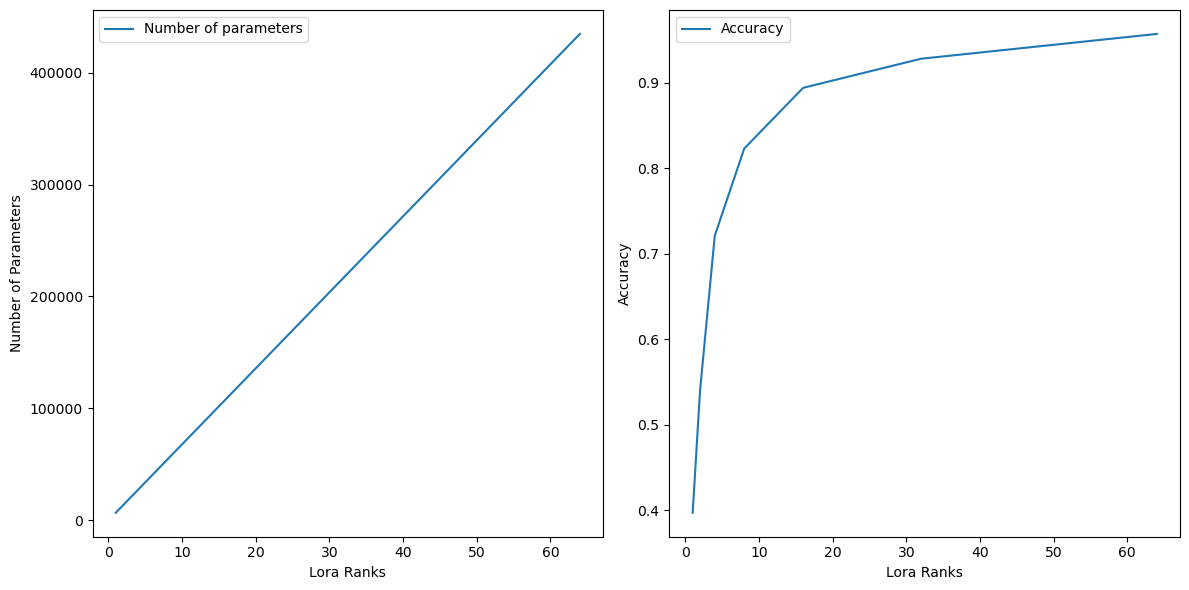

In [69]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lora_ranks, list(lora_params.values()), label="Number of parameters")
plt.xlabel("Lora Ranks")
plt.ylabel("Number of Parameters")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(lora_ranks, list(accuracies.values()), label="Accuracy")
# plt.hlines(accuracy_fine_tuning, xmin=lora_ranks[0], xmax=lora_ranks[-1], colors='red', label='Non Lora Fine tuning')
plt.xlabel("Lora Ranks")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()